In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import ast

2023-06-08 15:47:19.040984: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_df = pd.read_csv("train_data.csv")
test_df = pd.read_csv("test_data.csv")

In [3]:
train_df['category'] = train_df['category'].apply(ast.literal_eval)
test_df['category'] = test_df['category'].apply(ast.literal_eval)

In [4]:
train_categories_tensor = tf.ragged.constant(train_df["category"].values)
test_categories_tensor = tf.ragged.constant(test_df["category"].values)

# Convert TensorFlow tensors to numpy arrays
train_categories_array = train_categories_tensor.numpy()
test_categories_array = test_categories_tensor.numpy()

# Convert numpy arrays to sets of tuples
train_categories = set(tuple(x) for x in train_categories_array)
test_categories = set(tuple(x) for x in test_categories_array)

categories_not_in_train = test_categories - train_categories

print(categories_not_in_train)


set()


In [5]:
import tensorflow as tf
#
categories = tf.ragged.constant(train_df["category"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot", num_oov_indices=0)
lookup.adapt(categories)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


# Save your category labels to a file
with open('categories.txt', 'w') as f:
    for category in vocab:  # 'vocab' is your list of unique category labels
        f.write(f"{category}\n")

print("Vocabulary:\n")
print(vocab)

Vocabulary:

['Land use', 'other', 'Environment and climate resilience', 'Local identity', 'Future of work', 'Mobility (transport)']


2023-06-08 15:47:36.184688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant and shape [288]
	 [[{{node Placeholder/_0}}]]


In [6]:
sample_label = train_df["category"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Mobility (transport)', 'Future of work']
Label-binarized representation: [[0. 0. 0. 0. 1. 1.]]


In [7]:
train_df["Sentence"].apply(lambda x: len(x.split(" "))).describe()

count    288.000000
mean      13.864583
std       24.931664
min        1.000000
25%        5.000000
50%        8.000000
75%       13.000000
max      179.000000
Name: Sentence, dtype: float64

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_seqlen = 20
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["category"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["Sentence"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [9]:
vocabulary = set()
train_df["Sentence"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

1071


In [10]:
train_dataset = make_dataset(train_df, is_train=True)
test_dataset = make_dataset(test_df, is_train=False)

In [11]:
import numpy as np
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(label[0])
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")


[0. 0. 0. 1. 0. 0.]
Abstract: b'"history"'
Label(s): ['Local identity']
 
[0. 1. 0. 0. 0. 0.]
Abstract: b'"finish?"'
Label(s): ['other']
 
[0. 0. 1. 0. 0. 0.]
Abstract: b'"How can I do the insulation of a half timbered house?"'
Label(s): ['Environment and climate resilience']
 
[0. 1. 0. 0. 0. 0.]
Abstract: b'"Exactly!"'
Label(s): ['other']
 
[0. 0. 0. 0. 1. 0.]
Abstract: b'"hi, i think if there\xc2\xb4s more free use co-working space in the building would be great. The interior of the building should pay attention to the use of more recycled materials and clean energy. Also, it would be great if the building could break up the interior and exterior spaces and have more entrances and courtyards, small spaces for free use. Considering the problem of lighting, perhaps the building can use more transparent glass and light steel structure. This building stands for freedom, cooperation, and environmental friendliness."'
Label(s): ['Future of work']
 


2023-06-08 15:47:55.037896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [288]
	 [[{{node Placeholder/_0}}]]
2023-06-08 15:47:55.038278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [288,6]
	 [[{{node Placeholder/_1}}]]


In [12]:
from tensorflow.keras import layers
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# You need to adapt your vectorizer to the text data
text_vectorizer.adapt(train_df["Sentence"].values)

vocab2 = text_vectorizer.get_vocabulary()
with open('vocabulary.txt', 'w') as f:
    for word in vocab2:
        f.write(f"{word}\n")
print(vocab2)
# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)


['[UNK]', 'the', 'building', 'and', 'be', 'a', 'to', 'should', 'of', 'it', 'the building', 'have', 'i', 'for', 'you', 'in', 'that', 'would', 'should be', 'is', 'can', 'as', 'with', 'spaces', 'have a', 'it should', 'building should', 'more', 'do', 'use', 'think', 'there', 'on', 'how', 'like', 'students', 'of the', 'also', 'what', 'or', 'do you', 'could', 'would be', 'will', 'this', 'space', 'i think', 'many', 'in the', 'nice', 'for the', 'design', 'an', 'to the', 'should have', 'new', 'architecture', 'we', 'tum', 'open', 'on the', 'materials', 'about', 'so', 'not', 'be a', 'your', 'possible', 'i would', 'which', 'where', 'see', 'rooms', 'it would', 'floor', 'be nice', 'yes', 'work', 'well', 'there should', 'some', 'positive', 'if', 'green', 'great', 'environment', 'by', 'up', 'to see', 'the tum', 'the new', 'the environment', 'student', 'spaces for', 'place', 'nice to', 'my', 'look', 'good', 'existing', 'different', 'definitely', 'construction', 'at', 'are', 'a positive', 'would also', 

2023-06-08 15:48:01.871595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [288]
	 [[{{node Placeholder/_0}}]]
2023-06-08 15:48:01.872037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [288,6]
	 [[{{node Placeholder/_1}}]]


In [13]:
from collections import Counter
from itertools import chain

# Flatten the list of categories and count the occurrences
class_counts = dict(Counter(chain(*train_df['category'])))

# Calculate total number of samples
total_samples = len(train_df)

# Calculate class weights
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# Convert class_weights to tensor format
class_weights_tensor = tf.constant([class_weights[key] for key in sorted(class_weights.keys())])
class_weights

{'Mobility (transport)': 28.8,
 'Future of work': 7.384615384615385,
 'Environment and climate resilience': 4.721311475409836,
 'other': 4.114285714285714,
 'Local identity': 4.88135593220339,
 'Land use': 3.3488372093023258}

In [14]:
# After calculating class_weights_tensor
np.save('class_weights_tensor.npy', class_weights_tensor)

In [15]:
def make_model():
    shallow_mlp_model = tf.keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

Epoch 1/60
3/3 [==============================] - 3s 11ms/step - loss: 0.6860 - binary_accuracy: 0.7020 - precision: 0.2228 - recall: 0.2995 - f1_score: 0.2525
Epoch 2/60
3/3 [==============================] - 0s 12ms/step - loss: 0.5509 - binary_accuracy: 0.8131 - precision: 0.2385 - recall: 0.1522 - f1_score: 0.1851
Epoch 3/60
3/3 [==============================] - 0s 12ms/step - loss: 0.4901 - binary_accuracy: 0.7986 - precision: 0.3091 - recall: 0.1813 - f1_score: 0.2285
Epoch 4/60
3/3 [==============================] - 0s 11ms/step - loss: 0.4392 - binary_accuracy: 0.8275 - precision: 0.3441 - recall: 0.1704 - f1_score: 0.2277
Epoch 5/60
3/3 [==============================] - 0s 13ms/step - loss: 0.4050 - binary_accuracy: 0.8241 - precision: 0.3662 - recall: 0.1498 - f1_score: 0.2126
Epoch 6/60
3/3 [==============================] - 0s 10ms/step - loss: 0.3685 - binary_accuracy: 0.8461 - precision: 0.4150 - recall: 0.1575 - f1_score: 0.2283
Epoch 7/60
3/3 [========================

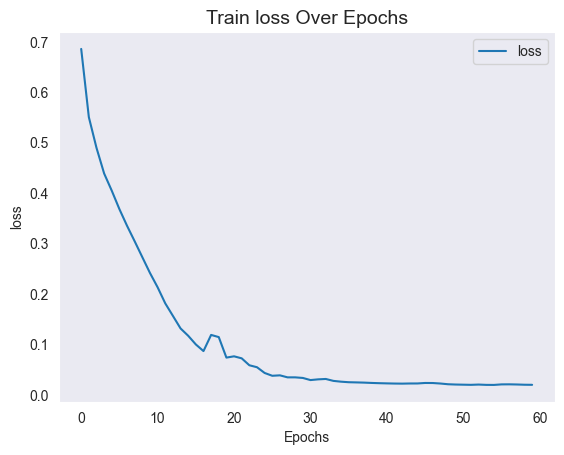

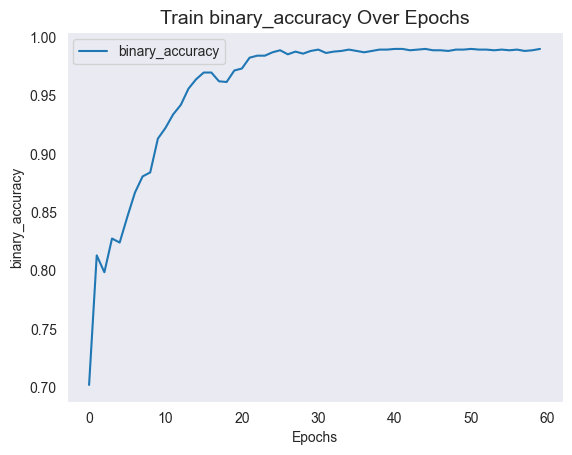

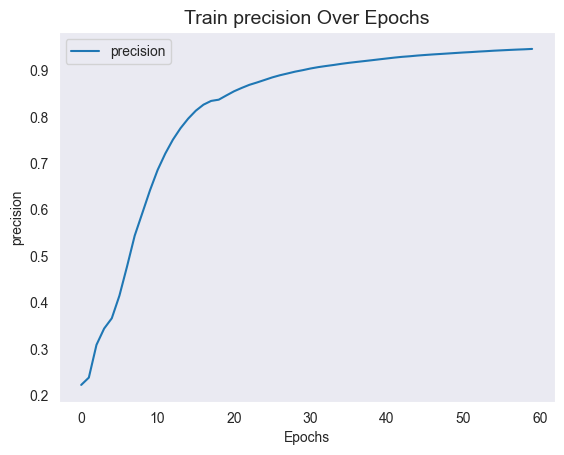

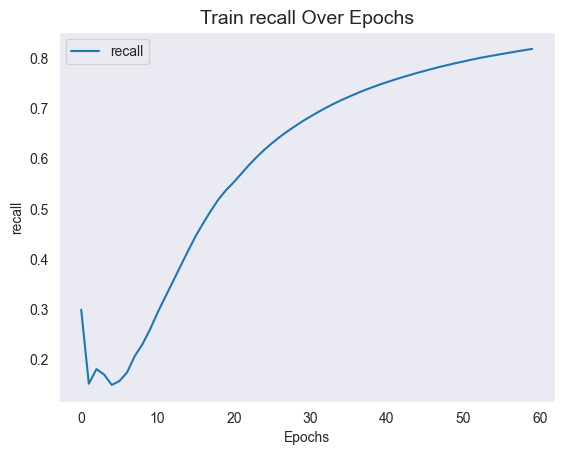

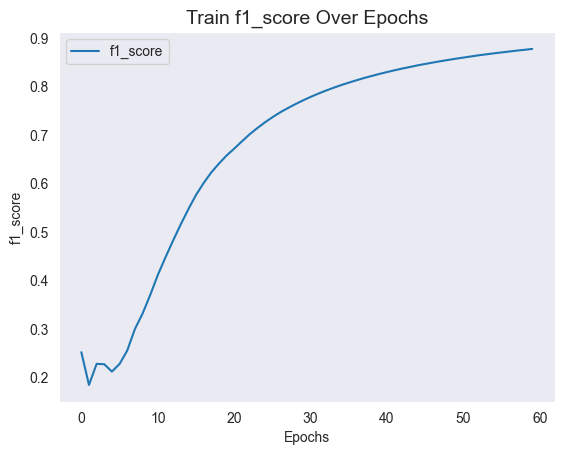

In [17]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.keras import metrics

import tensorflow as tf
#from tensorflow.keras import metrics

class F1Score(metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = metrics.Precision()
        self.recall = metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
       precision = self.precision.result()
       recall = self.recall.result()
       return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
# Define weighted loss function
def weighted_binary_crossentropy(y_true, y_pred):
    return tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, class_weights_tensor)


epochs = 60

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "binary_accuracy", #"binary_accuracy" checks for each position if the prediction is correct.
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        F1Score()
    ]
)

history = shallow_mlp_model.fit(train_dataset, epochs=epochs)
# Save the entire model as a SavedModel.
shallow_mlp_model.save('TFIDF_Model.h5')

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_result("loss")
plot_result("binary_accuracy")
plot_result("precision")
plot_result("recall")
plot_result("f1_score")


In [18]:
# Generate predictions on the test set
y_pred = shallow_mlp_model.predict(test_dataset)
def custom_round(y_pred, threshold):
    binary_predictions = np.zeros_like(y_pred)

    for i, row in enumerate(y_pred):
        if np.all(row < threshold):
            binary_predictions[i, np.argmax(row)] = 1
        else:
            binary_predictions[i] = np.round(row)

    return binary_predictions

binary_predictions = custom_round(y_pred, threshold=0.5)
binary_predictions

2023-06-08 15:51:14.460405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype int64
	 [[{{node Placeholder/_9}}]]
2023-06-08 15:51:14.460978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype int64
	 [[{{node Placeholder/_9}}]]


1/1 [==============================] - 0s 222ms/step


array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1.

In [19]:
y_true = np.vstack(test_dataset.map(lambda x, y: y).as_numpy_iterator())
y_true

2023-06-08 15:51:16.493030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1071]
	 [[{{node Placeholder/_10}}]]
2023-06-08 15:51:16.493593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1071]
	 [[{{node Placeholder/_10}}]]
/var/folders/jp/2wr1hx0s4zjdcnf63gtk75fw0000gq/T/ipykernel_3815/2842722914.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.v

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [0.

In [26]:
# Convert the binary labels to their actual names
predicted_labels = [invert_multi_hot(pred) for pred in binary_predictions]
true_labels = [invert_multi_hot(label) for label in y_true]
# Create the new dataset
new_dataset = pd.DataFrame({
    'Sentence': test_df['Sentence'],
    'Predicted Labels': predicted_labels,
    'True Labels': true_labels
})

# Save the new dataset to a csv file
# new_dataset.to_csv('new_dataset.csv', index=False)
new_dataset

,Sentence,Predicted Labels,True Labels
0,"""The building should have spaces for the stude...",[Local identity],[Land use]
1,"""a beautiful courtyard is also good""",[Environment and climate resilience],[Local identity]
2,"""Also, I know the Garching campus has a very f...",[Local identity],[Local identity]
3,"""I think that a good architecture school shoul...",[Local identity],"[Land use, Local identity]"
4,"""comfortable spaces and facilities for both st...",[Land use],[Future of work]
...,...,...,...
67,"""What aggregate should I use for the infra lig...",[Land use],[Land use]
68,"""a big entrance hall with a meeting point for ...",[Land use],[Future of work]
69,"""There should be a makerspace for model making.""",[Environment and climate resilience],[Land use]
70,"""But it can be a very challenging goal to achi...",[Land use],[other]


In [27]:
new_dataset.to_csv("predictions_vs_true_TFIDF.csv")

In [28]:
manual_pred = pd.read_csv("predictions_vs_true_TFIDF_var.csv")

In [30]:
def get_true_prediction(row):
    if row['Validation'] == 'V':
        return row['Predicted Labels']
    elif row['Validation'] == 'X':
        return row['True Labels']
    else:
        return None

manual_pred['true prediction'] = manual_pred.apply(get_true_prediction, axis=1)


In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def eval(category):
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in manual_pred.index:
        if category in manual_pred['true prediction'][i] and category in manual_pred['Predicted Labels'][i]:
            TP += 1
        elif category in manual_pred['Predicted Labels'][i] and category not in manual_pred['true prediction'][i]:
            FP +=1
        elif category in manual_pred['true prediction'][i] and category not in manual_pred['Predicted Labels'][i]:
            FN +=1
        elif category not in manual_pred['true prediction'][i] and category not in manual_pred['Predicted Labels'][i]:
            TN +=1

    accuracy = (TP + TN) / (TP + TN + FN + FP) if (TP + TN + FN + FP) != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    F1score = 2*precision*recall / (precision + recall) if (precision + recall) != 0 else 0

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {F1score}")

    confusion_matrix = pd.DataFrame({
        'Predicted Positive': [TP, FP],
        'Predicted Negative': [FN, TN]
    }, index=['Actual Positive', 'Actual Negative'])

    plt.figure(figsize=(5,5))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap='Blues')
    plt.title(f"Confusion Matrix for '{category}'")
    plt.show()

Accuracy: 0.7638888888888888
Precision: 0.35714285714285715
Recall: 0.38461538461538464
F1 Score: 0.3703703703703704


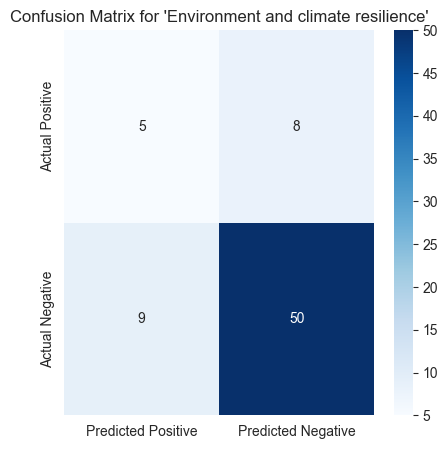

Accuracy: 0.8055555555555556
Precision: 0.7222222222222222
Recall: 0.5909090909090909
F1 Score: 0.65


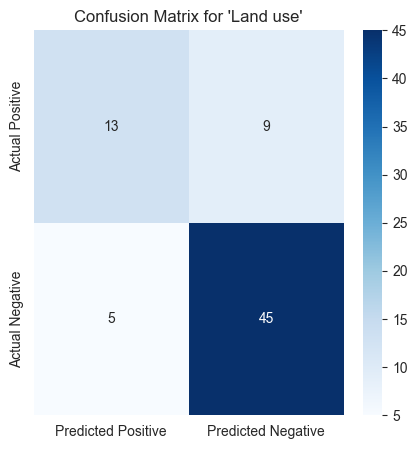

Accuracy: 0.9166666666666666
Precision: 0.5
Recall: 0.3333333333333333
F1 Score: 0.4


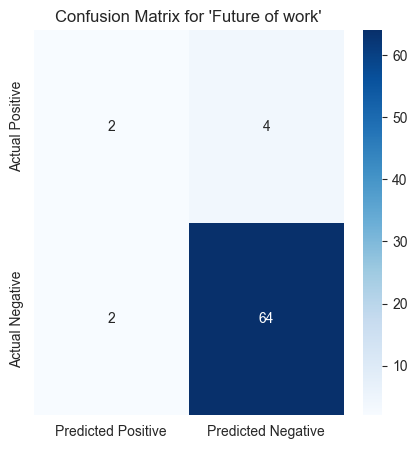

Accuracy: 0.8472222222222222
Precision: 0.5909090909090909
Recall: 0.8666666666666667
F1 Score: 0.7027027027027029


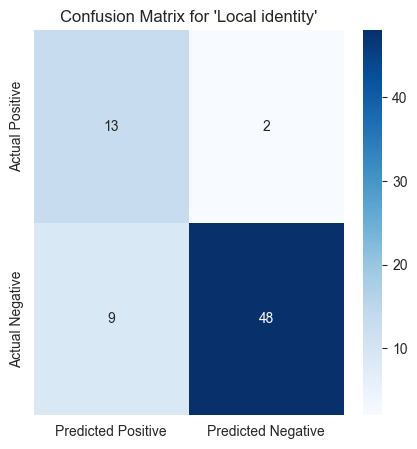

Accuracy: 0.9722222222222222
Precision: 0
Recall: 0.0
F1 Score: 0


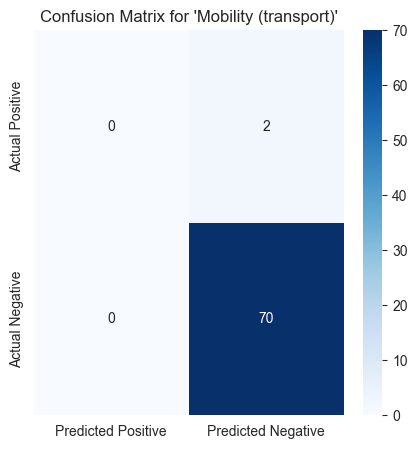

Accuracy: 0.8472222222222222
Precision: 0.7368421052631579
Recall: 0.7
F1 Score: 0.717948717948718


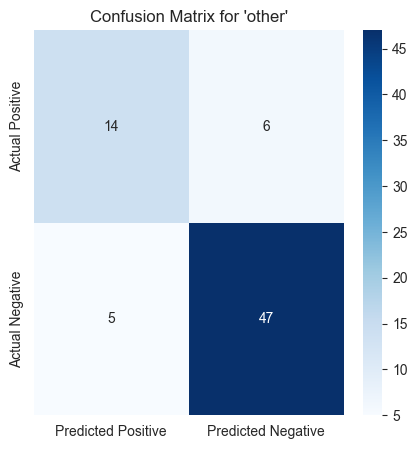

In [32]:
eval('Environment and climate resilience')
eval('Land use')
eval('Future of work')
eval('Local identity')
eval('Mobility (transport)')
eval('other')

In [176]:
# Flatten the list of categories
flat_categories = [category for sublist in train_df["category"] for category in sublist]

# Count the occurrences
counts = Counter(flat_categories)

# Print counts in a readable format
for category, count in counts.items():
    print(f" {category}' : {count} .")

 Mobility (transport)' : 10 .
 Future of work' : 39 .
 Environment and climate resilience' : 61 .
 other' : 70 .
 Local identity' : 59 .
 Land use' : 86 .


In [33]:
# Flatten the list of categories
flat_categories = [category for sublist in test_df["category"] for category in sublist]

# Count the occurrences
counts = Counter(flat_categories)

# Print counts in a readable format
for category, count in counts.items():
    print(f" {category}' : {count} .")

 Land use' : 22 .
 Local identity' : 14 .
 Future of work' : 9 .
 other' : 18 .
 Environment and climate resilience' : 15 .
 Mobility (transport)' : 2 .
